# Do Android Wolves Dream of Electric Sheep?

### A demonstration of the Artificial Agent Based Model

This notebook demonstrates the operation of our agent based model using various AI-based and non AI-based approaches.

We will demonstrate the operation of a standard Lotka-Volterra system of predators and prey, using wolves and sheep as the hypothetical animals. That system demonstrates a natural sucession between species as interaction between primary (prey) and scecodary (predatory) consumers leads to cyclical population fluctuations.

While Lotka-Volterra is sensitive as a system to over-predation by "wolves" and collapse of the "sheep" (and thus wolves),
in the real world predators might prevent these collapses by "guarding their territory" and substituting some of
their prey-hunting time and energy with aggression toward other predators. In our version of Lotka Volterra, we model
this territorial behavior as $\theta$ (*theta*).

But, how can we capture the dynamic application of this variable to the system in a way that best emulates what a wolf would do?

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

# Fix the import path
from model.model import run

# Here are the available parameters you can set:
#
# Core simulation parameters:
# - steps: Number of simulation steps to run (default: 250)
# - dt: Time step size (default: 0.02)
# - s_start: Initial sheep population (default: 100)
# - w_start: Initial wolf population (default: 10)
# - sheep_max: Maximum sheep capacity (default: 110)
#
# Wolf behavior parameters:
# - no_ai: If True, wolves use fixed theta; if False, wolves use AI (default: False)
# - prompt_type: "high", "medium" or "low" (default: "high")... amount of information provided to the wolves
# - theta_star: Default theta value when no_ai=True (default: 0.5)
# - churn_rate: Percentage of wolves that update their theta each step (default: 0.05)
# - threads: Number of parallel LLM calls when using async mode (default: 5)
#
# Wolf population dynamics parameters:
# - beta: Predation rate (default: 0.1)
# - gamma: Wolf death rate (default: 1.5)
# - delta: Conversion efficiency (default: 0.75)
#
# Sheep population dynamics parameters:
# - alpha: Sheep growth rate (default: 1)
# - eps: Small value to prevent extinction (default: 0.0001)
#
# Output parameters:
# - save_results: Whether to save simulation results (default: True)
# - path: Directory to save results (default: "../data/results")

# NOTE: Do not set `no_ai` or `prompt_type` or `theta_star` or `steps` here,
#  ... they will be set in the calls below

my_args = {
        "model_name": "gpt-4o-mini",
        "temperature": 0.2,
        "max_tokens": 4096,
        "churn_rate": 0.1,
        "dt": 0.02,
        "sheep_max": 110,
        "eps": 0.0001,
        "alpha": 1,
        "beta": 0.1,
        "gamma": 1.5,
        "delta": 0.75,
        "s_start": 100,
        "w_start": 10,
        "step_print": False,
}


## Functional Wolves (no_ai)

### Theta as a constant.

In the following examples, we look at $\theta$ as a constant value that modifies the base LV functions. For review, those are:

Standard Lotka-Volterra differential equations:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \beta sw \\
\frac{dw}{dt} &= -\gamma w + \delta\beta sw
\end{align}
$$

We can insert our new variable, theta, as a factor on the equations to modify the impact of predation on the population. So:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \theta\beta sw \\
\frac{dw}{dt} &= -\gamma w + \delta\theta\beta sw
\end{align}
$$

In our implementation we can supply a theta value, which we set as $\theta^*$ or `theta_star` if we want the value to remain constant over the course of the run.

We can see from the equations above that if we apply a $\theta^*$ of 1, the outcome is as if the variable isnʻt even there: we get our "base" Lotka-Volterra behavior:


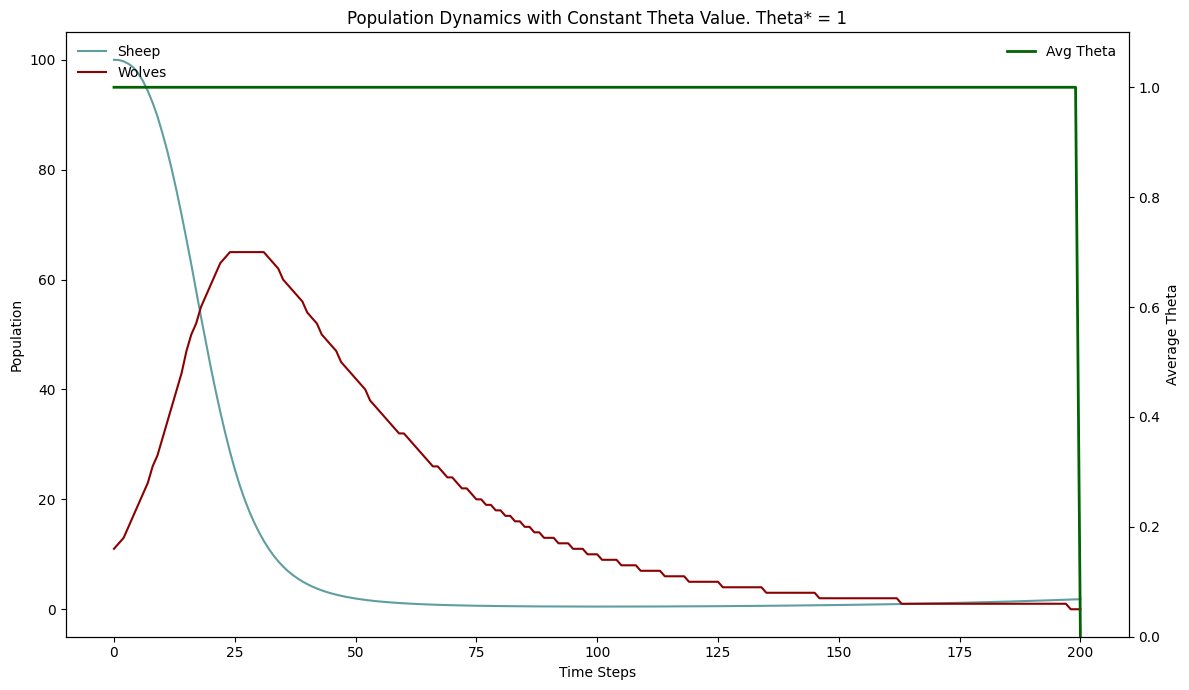

In [2]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    theta_star=1,
    steps=200,
    no_ai=True,
    save_results=True
    )

Here we have a base Lotka-Volterra system output as we would expect. Note that the wolf population is made up of individual "agents" in our implementation, so the population graph for the wolves is "blocky." It moves in steps, unlike the sheep population.

The crash to zero is a standard outcome for the textbook LV system with the variables we used to start (10 wolves, 100 sheep.) And, again, remember, we have theta set in this version of the system--it is just that at 1, it appears invisible.

We can try setting theta as 0 instead... In this case, our wolves do not eat. They starve. Another population collapse.

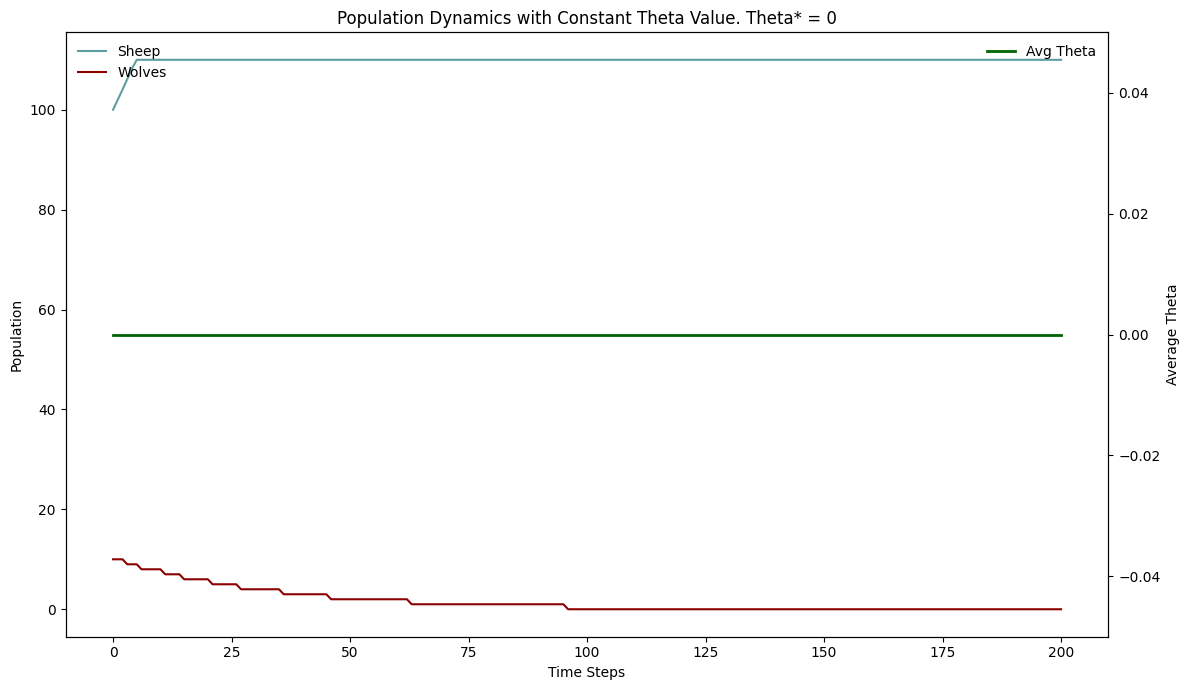

In [3]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    theta_star=0,
    steps=200,
    no_ai=True,
    save_results=True
    )

Or we can try a value in between:

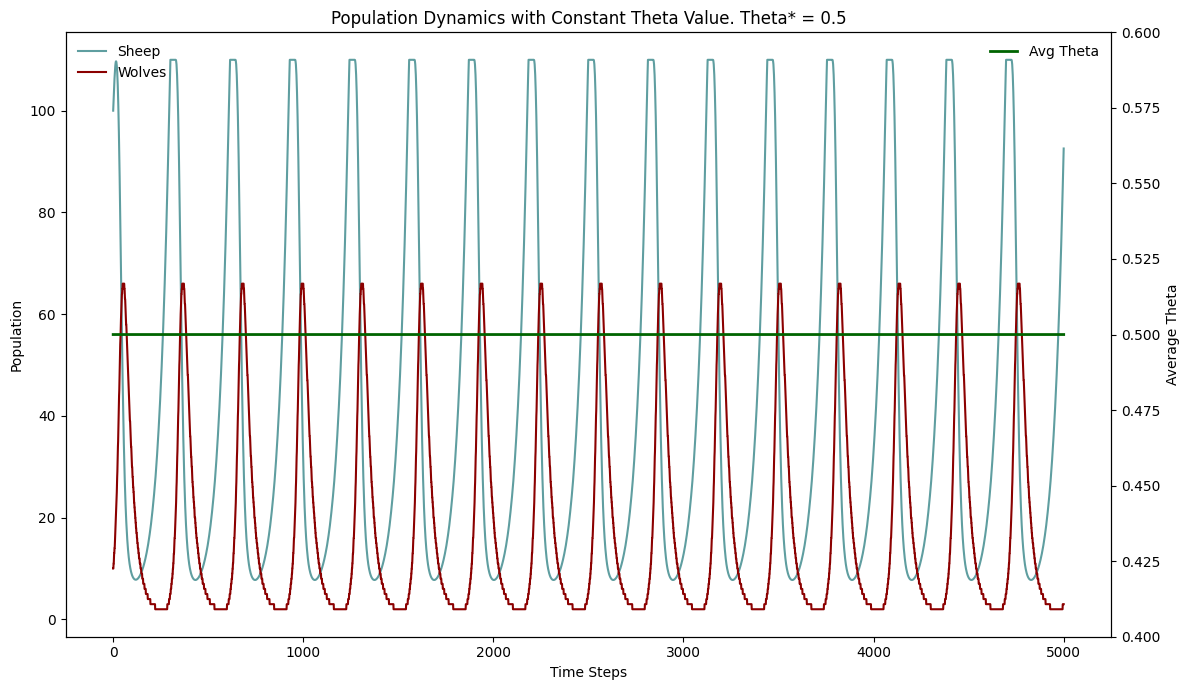

In [4]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    theta_star=0.5,
    steps=5000,
    no_ai=True,
    save_results=True
    )

In fact, theta_star = 0.5 works as a great stabilizer for our model over very many cycles, with our default model values, anyway.

## Functional Wolves (no_ai)

### Theta as a programmed variable.

In this example, no AIs are used for setting theta, but it has a variable value. Instead, we rely on a function that is sensitive to the populations of sheep and wolves.

Hinting at a function takes us to a very important point. In The Subliminal Wolf (herein TSW), we implemented a basic $\theta$ variable, but it had to be implemented as a function to be sensitive to scarcity in ways that LV (and thus wolves!) are not. There are examples of settings for the function in TSW that give us a feeling for how a dynamically-set $\theta$ will work with our population dynamics. 

For instance:

$$
\begin{align}
\theta(s) = \frac{1}{1 + k\frac{s_0}{s + \varepsilon}} \text{ for some constant } k > 0. \tag{3}
\end{align}
$$

The above describes one possible functioning of a theta factor that is sensitive to prey scarcity. When combined with our "modified" LV above (both lines (1) and (2)), it can yield modified behavior that for specific values will stablize the overall population. This should work for k = 1 with default model settings. k is a sensitivity factor. However, different values of dt (different stepping "rythyms") could cause k = 1 to not be an effective stablizing value for the function.



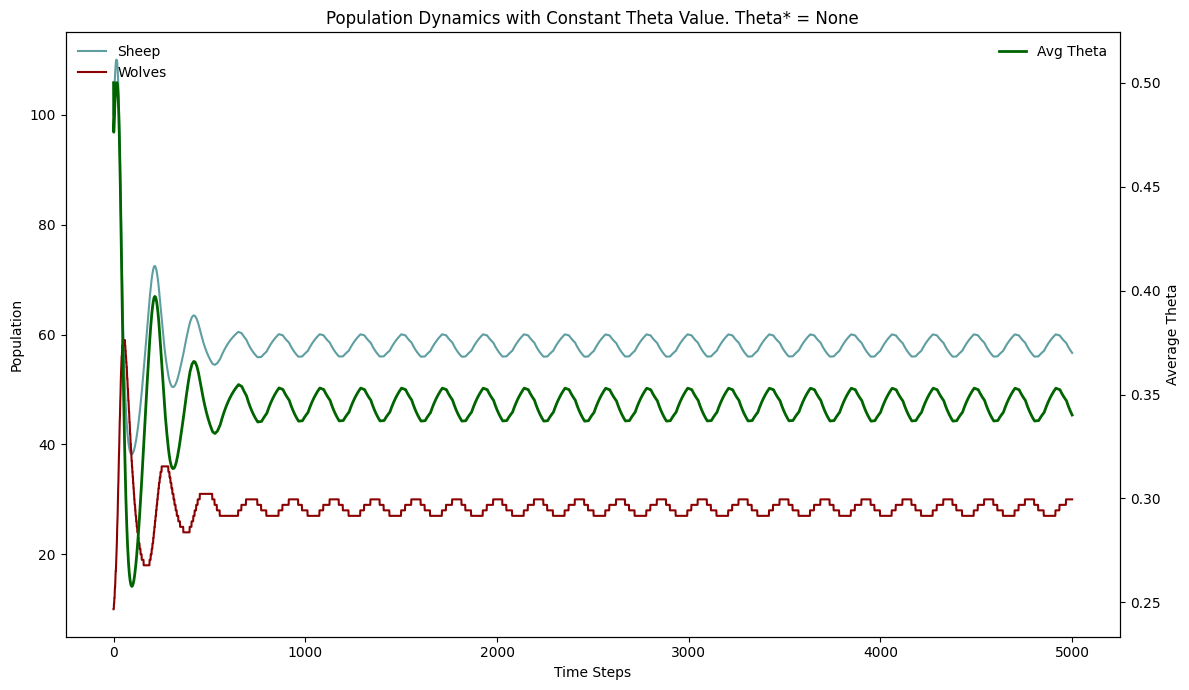

In [5]:
# Run model with no_ai=True (note the correct keyword argument syntax)
results = run(
    **my_args,
    k = 1,
    steps=5000,
    no_ai=True,
    save_results=True
    )

This is a nicely-modulating function, although, again, may not be fully stabilizing for every starting state of the model variables.

# AI (LLM) Decision Emulating Wolves

What if, instead of using a constant theta value, or a function, we wanted to use a more "organic" approach to setting the degree of competitiveness displayed
by our predators? It turns out that we can emulate this very thing---that is, we can generate results based on a system that attempts to act like a wolf.
We can do this by using AI Large Language Models (LLM). In this example we will focus on one specific LLM, ChatGPT 4o, but we could use many other models that exist.

## High Information AI Wolves

In the following simulation, we prompt the LLMs with a comprehensive view of the scenario and model conditions at each prompt. We explain what the settings of theta will do to the environment generally, but we do not give quantitative advice outside of requiring an output between 0 and 1. We suggest detailed scenario dynamics and how they might be handled, although again the advice is qualitative and not quantitative.

Final sheep population: 53.43279656543944
Final wolf population: 26
Thetas: [0.5, 0.575, 0.63, 0.7090909090909091, 0.6827715471220369, 0.7202715471220369, 0.7657463679224743, 0.7603135188661444, 0.7652381902775176, 0.7241712905778168, 0.7583338574687579, 0.7656168827097304, 0.7457516689268757, 0.7293581932606141, 0.7377206798636096, 0.7618297863145294, 0.7700575829806767, 0.7696708232002263, 0.7384397787484014, 0.7094400862875861, 0.6689073681926806, 0.6554618711372454, 0.6440541471320286, 0.6197634457705394, 0.6108276389162282, 0.6136493310415512, 0.590520087787664, 0.5829634359236705, 0.5720488536093596, 0.5608993110704532, 0.5538406418159535, 0.5392504333470058, 0.5407721891325357, 0.5345221891325357, 0.5395077025289687, 0.5298585797219512, 0.5191552904549165, 0.5131208076962958, 0.5096725318342268, 0.503638049075606, 0.49672753339343323, 0.48810684373826085, 0.47776201615205394, 0.4672102111483725, 0.4622249795046137, 0.4491224738426957, 0.4412277370005905, 0.4357139465898867, 0.42

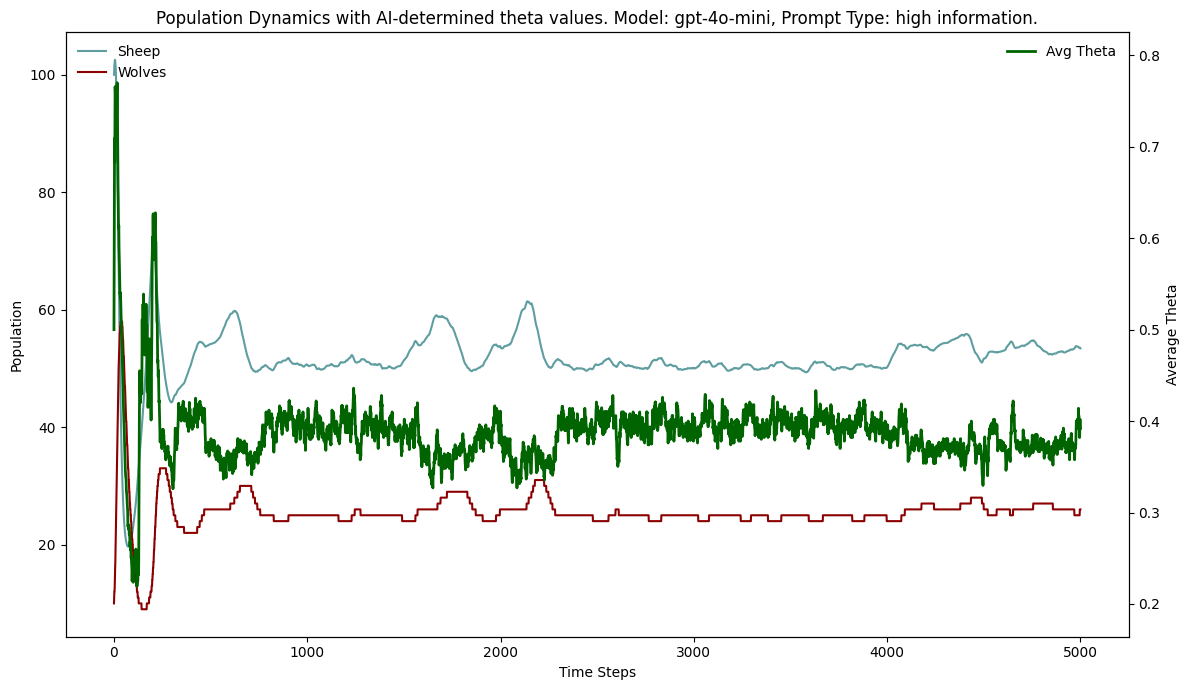

In [6]:
# Run model with AI-enabled wolves
ai_results = run(
    **my_args,
    no_ai=False,
    steps=5000,
    save_results=True,
    prompt_type="high"
)

# Print some information about the results
print(f"Final sheep population: {ai_results['sheep_history'][-1]}")
print(f"Final wolf population: {ai_results['wolf_history'][-1]}")
print(f"Thetas: {ai_results['average_theta_history']}")

## Medium Information Wolves

In the following simulation, we prompt the LLMs with a comprehensive view of the scenario and model conditions at each prompt. We explain what the settings of theta will do to the environment generally, but we do not give quantitative advice outside of requiring an output between 0 and 1.

Final sheep population: 23.71016744770413
Final wolf population: 7
Thetas: [0.5, 0.475, 0.475, 0.49000000000000005, 0.45454545454545453, 0.440909090909091, 0.4725, 0.4708333333333334, 0.4594002349038343, 0.44786177336537275, 0.47738068169925363, 0.46, 0.42, 0.4307357316984305, 0.42136073169843047, 0.44204665747661576, 0.4273206503986049, 0.40184818415954243, 0.38605871047533186, 0.40955201719487555, 0.4043352544713101, 0.3972272241511851, 0.4014094384098339, 0.3837302343263353, 0.3857773504012018, 0.392055327521649, 0.3763462563851537, 0.3829450484619532, 0.3679434926683776, 0.35992590958331727, 0.35176852041204815, 0.3603892100672206, 0.3550429030649799, 0.3752447347922348, 0.39265744387115525, 0.3838489614547665, 0.39912039170053676, 0.38514046166449295, 0.39758263845922304, 0.4094883584997698, 0.42536374965474366, 0.43595038222330046, 0.44774091160270446, 0.45388490827161826, 0.45694866958322955, 0.4681414183334382, 0.472044122578225, 0.48186404984537035, 0.4768306149905926, 0.47025

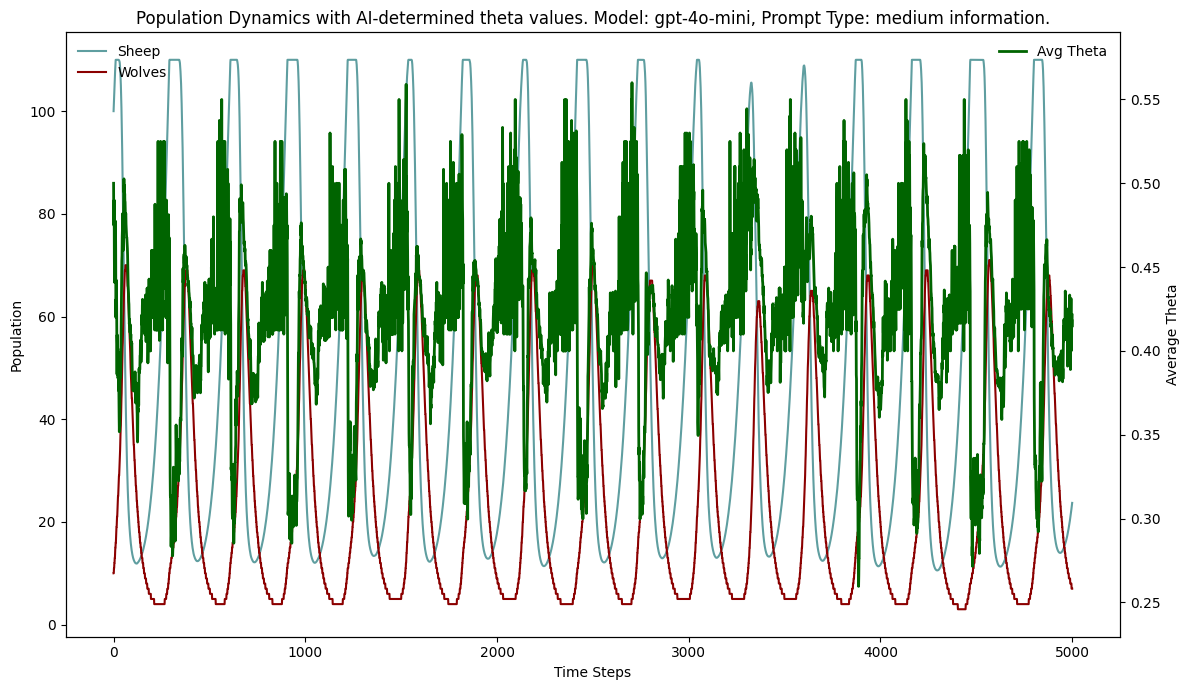

In [7]:
# Run model with AI-enabled wolves
ai_results_low = run(
    **my_args,
    no_ai=False,
    steps=5000,
    save_results=True,
    prompt_type="medium"
)

# Print some information about the results
print(f"Final sheep population: {ai_results_low['sheep_history'][-1]}")
print(f"Final wolf population: {ai_results_low['wolf_history'][-1]}")
print(f"Thetas: {ai_results_low['average_theta_history']}")

## Low Information AI Wolves

In the following demonstration, we prompt the LLMs with a very basic amount of information about the scenario and the current conditions. We explain how high and low theta work to indicate aggression levels. We ask for a value between 0 and 1; no other quantitative advice is given.

Final sheep population: 35.10408024660166
Final wolf population: 17
Thetas: [0.5, 0.61, 0.65, 0.5988917188675624, 0.5488917188675623, 0.5739840756285989, 0.5308211869660446, 0.5077442638891216, 0.5286196736113272, 0.5567116953705721, 0.5319167396507879, 0.5262952489822613, 0.5286089057815198, 0.5271659817635808, 0.4966500735939914, 0.4877517865458569, 0.43165816526165335, 0.4303460835294492, 0.43467236396132114, 0.4440696537903241, 0.4776954594918068, 0.5131687110498142, 0.4825901094819165, 0.5158256685503363, 0.5232856985458404, 0.5351751358767514, 0.5313411142903965, 0.5436538045907443, 0.5371249371284247, 0.5329608973179756, 0.5217888555381494, 0.5414595746108904, 0.5213661831483709, 0.489257293751003, 0.5030218894652415, 0.4982021083920712, 0.5062178014642194, 0.5155583641612626, 0.516168226803652, 0.5076617297617358, 0.5166484891802379, 0.5195999941880315, 0.5116096768667152, 0.5144066869799969, 0.5152873668292399, 0.5020053932867178, 0.5059621145690911, 0.5064911137689778, 0.5126

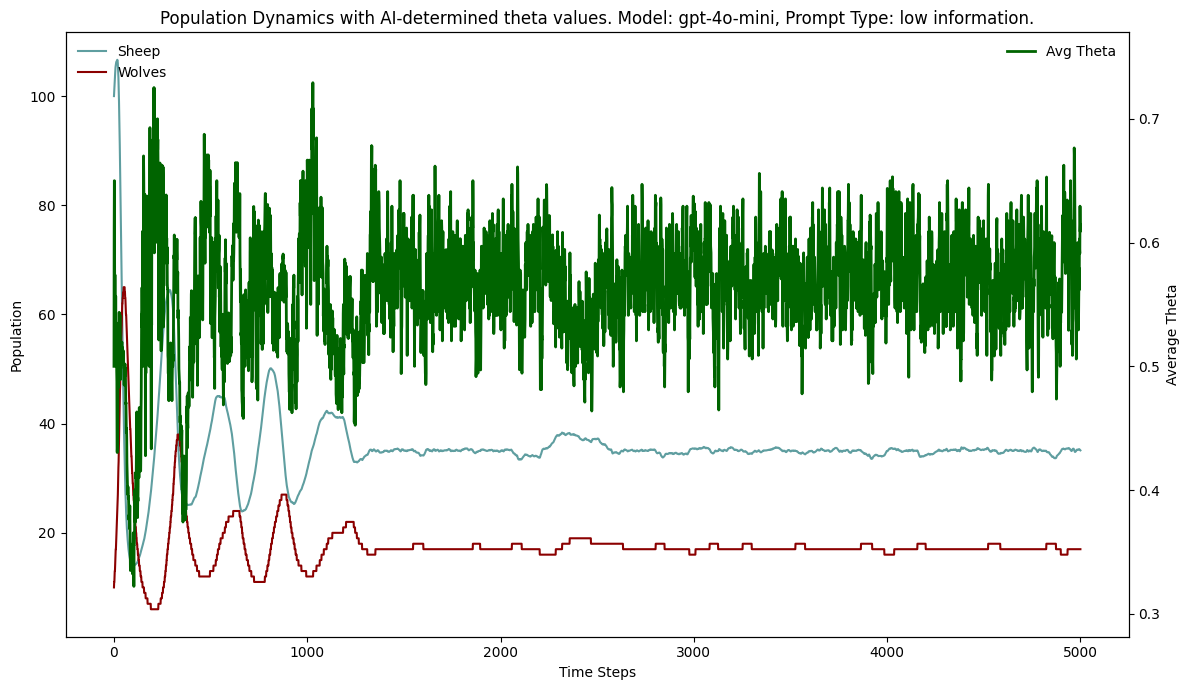

In [8]:
# Run model with AI-enabled wolves
ai_results_low = run(
    **my_args,
    no_ai=False,
    steps=5000,
    save_results=True,
    prompt_type="low"
)

# Print some information about the results
print(f"Final sheep population: {ai_results_low['sheep_history'][-1]}")
print(f"Final wolf population: {ai_results_low['wolf_history'][-1]}")
print(f"Thetas: {ai_results_low['average_theta_history']}")